In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

import pickle

In [49]:
df = pd.read_csv("../data/train.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Exploratory Data Analysis

In [50]:
df.info()
df.describe()

# Find missing values
df.isnull().sum().sort_values(ascending=False).head(20)

# Correlation with SalePrice
corr = df.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False)
corr.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

# Feature Selection

In [51]:
# Simple selection by data types
# target = "SalePrice"
# x = df.drop(columns=[target])
# y = df[target]

# numeric_features = x.select_dtypes(include=['int64', 'float64']).columns
# categorical_features = x.select_dtypes(include=['object']).columns


# Selection based on Domain Knowledge
selected_features = [
    "OverallQual",      # Overall material & finish quality
    "GrLivArea",        # Above ground living area
    "GarageCars",       # Garage capacity (# cars)
    "GarageArea",       # Garage area in sq ft
    "TotalBsmtSF",      # Basement area in sq ft
    "1stFlrSF",         # First floor square footage
    "FullBath",         # Number of full bathrooms
    "YearBuilt",        # Original construction date
    "YearRemodAdd",     # Remodel year
    "LotArea",          # Lot size (sq ft)
    "KitchenQual"       # Kitchen quality (categorical)
]

x = df[selected_features]
y = df["SalePrice"]

numeric_features = [
    "OverallQual", "GrLivArea", "GarageCars", "GarageArea", 
    "TotalBsmtSF", "1stFlrSF", "FullBath", "YearBuilt", 
    "YearRemodAdd", "LotArea"
]

categorical_features = ["KitchenQual"]

## Visual Chart on Domain Knowledge

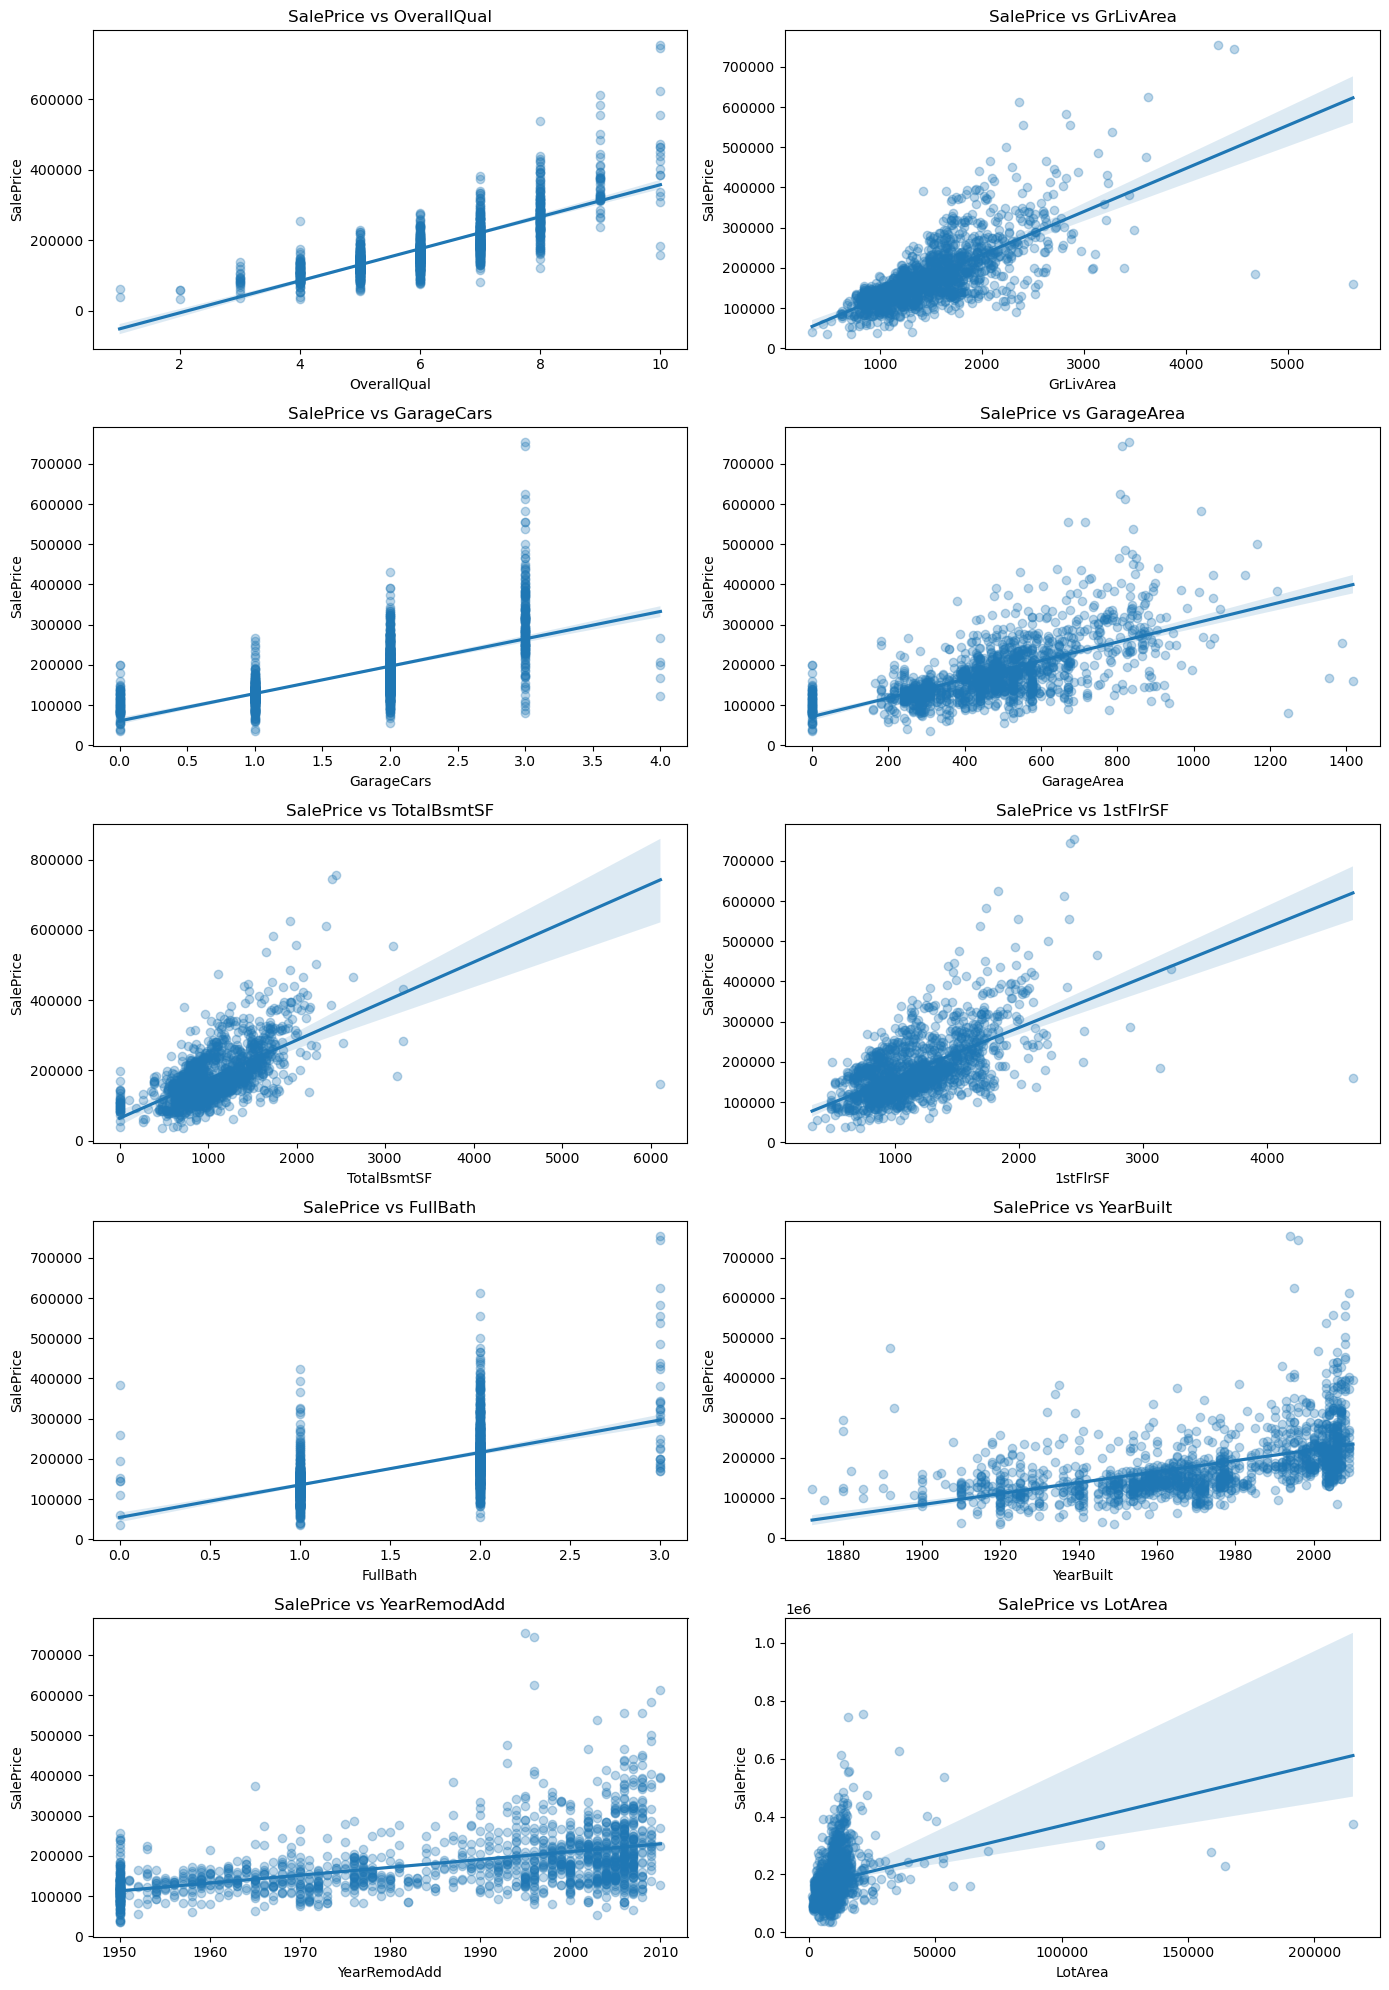

In [52]:
plt.figure(figsize = (14, 20))

for i, feature in enumerate(numeric_features):
    plt.subplot(5, 2, i + 1)
    sns.regplot(x = df[feature], y = df["SalePrice"], scatter_kws = { 'alpha':0.3 })
    plt.title(f"SalePrice vs {feature}")

plt.tight_layout()
plt.show()

# Preprocessing

In [53]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Models

## Linear Regression Pipeline

In [72]:
linear_model = Pipeline(
    steps = [
        ('preprocess', preprocessor),
        ('model', LinearRegression())
    ]
)

linear_model.fit(x, y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['OverallQual', 'GrLivArea',
                                                   'GarageCars', 'GarageArea',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   'FullBath', 'YearBuilt',
                                                   'YearRemodAdd', 'LotArea']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['KitchenQual'])])),
                ('model', LinearRegression())])

## Ridge Regression

In [73]:
ridge = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', Ridge())
])

ridge_params = { 'model__alpha': [0.1, 1, 10, 50, 100] }
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_root_mean_squared_error')
ridge_grid.fit(x, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['OverallQual',
                                                                          'GrLivArea',
                                                                          'GarageCars',
                                                                          'GarageArea',
                                                                          'TotalBsmtSF',
                                                                          '1stFlrSF',
                                                                          'FullBath',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'LotArea']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['KitchenQual'])])),
                                       ('model', Ridge())]),
             param_grid={'model__alpha': [0.1, 1, 10, 50, 100]},
             scoring='neg_root_mean_squared_error')

## LASSO Regression

In [77]:
lasso = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', Lasso(max_iter=5000))
])

lasso_params = { 'model__alpha': [0.0005, 0.001, 0.01, 0.1, 1, 10] }
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_root_mean_squared_error')
lasso_grid.fit(x, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['OverallQual',
                                                                          'GrLivArea',
                                                                          'GarageCars',
                                                                          'GarageArea',
                                                                          'TotalBsmtSF',
                                                                          '1stFlrSF',
                                                                          'FullBath',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'LotArea']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['KitchenQual'])])),
                                       ('model', Lasso(max_iter=5000))]),
             param_grid={'model__alpha': [0.0005, 0.001, 0.01, 0.1, 1, 10]},
             scoring='neg_root_mean_squared_error')

## Evaluation Function

In [66]:
def evaluate(model, x, y):
    # generate predicted prices
    predictons = model.predict(x)
    # square rooted average of (prediction - real)²
    root_mean_sq_err = np.sqrt(mean_squared_error(y, predictons))
    # average of |prediction - real|
    mean_abs_err = mean_absolute_error(y, predictons)
    # Model accuracy (0-1)
    r_sq = r2_score(y, predictons)

    return root_mean_sq_err, mean_abs_err, r_sq

## Model Comparison

In [78]:
results = {
    "Linear": evaluate(linear_model, x, y),
    "Ridge": evaluate(ridge_grid.best_estimator_, x, y),
    "LASSO": evaluate(lasso_grid.best_estimator_, x, y)
}

pd.DataFrame(results, index=["Root Mean Square Error", "Mean Absolute Error", "Coefficient of Determination"])

,Linear,Ridge,LASSO
Root Mean Square Error,35481.117602,35499.916332,35481.223615
Mean Absolute Error,21806.923639,21803.624136,21807.124535
Coefficient of Determination,0.800388,0.800177,0.800387


## Picking out the best model

In [81]:
model_map = {
    "Linear": linear_model,
    "Ridge": ridge_grid.best_estimator_,
    "LASSO": lasso_grid.best_estimator_
}

best_model_name = min(results, key=lambda m: results[m][0])
best_model = model_map[best_model_name]

print("Metrics (RMSE, MAE, R2):", results[best_model_name])
print("Best Model:", best_model_name)

with open("../models/final_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

Metrics (RMSE, MAE, R2): (np.float64(35481.11760191429), 21806.92363864907, 0.8003881548835607)
Best Model: Linear
